**WE FIRST IMPORT ALL THE REQUIRED PACKAGES**

In [1]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, initializers
from keras.layers import *
from keras.models import * 
from keras.utils import *
from keras.preprocessing import image
import tensorflow as tf
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

**MOUNTING OUR GOOGLE DRIVE FOR ACCESSING ALL THE FOLDERS, FILES AND BEING ABLE TO READ AND WRITE OUR FILES**

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


**WE DIVIDE THE TASK INTO MULTIPLE STAGES IN ORDER TO SUCCESSFULLY ANALYZE EACH STEP AND MODEL**

**1) CONSTRUCTING A SIMPLE MODEL**

AS WE SEE THROUGH THE METADATA OF THE DATASET DOWNLOADED FROM HERE - https://github.com/ieee8023/covid-chestxray-dataset IT CONTAINS IMAGE FILENAMES OF ALL THE COLUMN NAMES - "finding" AND "RT_PCR_POSITIVE" WHICH CONTAINS ENTRIES AS - "Pneumonia/Viral/COVID-19" AND "Y" RESPECTIVELY, THEREBY ABSOLUTELY CONFIRMING THE PRESENCE OF COVID-19.

In [3]:
FILE_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/covid-chestxray-dataset-master/metadata.csv"
IMAGES_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/covid-chestxray-dataset-master/images"

In [4]:
df=pd.read_csv(FILE_PATH)
print(df.shape)

(950, 30)


In [5]:
df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


WE MAKE "TRAIN" AND "TEST" FOLDERS CONTAINING "NORMAL" AND "COVID" SUB-FOLDERS IN EACH FOLDER. WE THEN MOVE OUR IMAGES TO EACH FOLDER BY USING PYTHON COMMANDS

In [6]:
FORTESTINGDATASET_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset"
if not os.path.exists(FORTESTINGDATASET_DIR):
  os.mkdir(FORTESTINGDATASET_DIR)
TRAIN_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/train"
TRAIN_COVID_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/train/covid"
TRAIN_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/train/normal"
TEST_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test"
TEST_COVID_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/covid"
TEST_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/normal"
KAGGLE_FILE_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (Pneumonia)/chest_xray/train/NORMAL"
if not os.path.exists(TRAIN_DIR):
  os.mkdir(TRAIN_DIR)
  os.mkdir(TRAIN_COVID_DIR)
  os.mkdir(TRAIN_NORMAL_DIR)
  os.mkdir(TEST_DIR)
  os.mkdir(TEST_COVID_DIR)
  os.mkdir(TEST_NORMAL_DIR)
print("folders created")

folders created


In [ ]:
count = 0
for (i,row) in df.iterrows():
  if row["finding"] == "Pneumonia/Viral/COVID-19" and row["RT_PCR_positive"] == "Y" and row["view"] == "PA" :
    filename = row["filename"]
    image_path = os.path.join(IMAGES_PATH,filename)
    image_copy_path = os.path.join(TRAIN_COVID_DIR,filename)
    shutil.copy2(image_path,image_copy_path)
    count+=1
print("Copied +ve covid files to training data folder = ",count)

Copied +ve covid files to training data folder 110


In [ ]:
image_names = os.listdir(KAGGLE_FILE_PATH)
random.shuffle(image_names)

In [ ]:
count = 0
for i in range(110):
  image_name1 = image_names[i]
  image_path1 = os.path.join(KAGGLE_FILE_PATH,image_name1)
  target_path1 = os.path.join(TRAIN_NORMAL_DIR,image_name1)
  shutil.copy2(image_path1,target_path1)
  count+=1
print("copied normal images to training folder = ",count)

copied normal images to training folder 110


WE RANDOMLY MOVE SOME IMAGES FROM TRAINING FOLDER TO THE TEST FOLDER

In [ ]:
image_names = os.listdir(TRAIN_NORMAL_DIR)
random.shuffle(image_names)
count = 0
for i in range(20) :
  image_name2 = image_names[i]
  image_path2 = os.path.join(TRAIN_NORMAL_DIR,image_name2)
  target_path2 = os.path.join(TEST_NORMAL_DIR,image_name2)
  shutil.move(image_path2,target_path2)
  count+=1
print("Moved normal images to test folder = ",count)

Moved normal images to test folder 20


In [ ]:
image_names = os.listdir(TRAIN_COVID_DIR)
random.shuffle(image_names)
count = 0
for i in range(20) :
  image_name3 = image_names[i]
  image_path3 = os.path.join(TRAIN_COVID_DIR,image_name3)
  target_path3 = os.path.join(TEST_COVID_DIR,image_name3)
  shutil.move(image_path3,target_path3)
  count+=1
print("Moved covid images to test folder = ",count)

Moved covid images to test folder 20


In [7]:
TRAIN_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/train"
VAL_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test"

CONSTRUCTING MODEL, GENERATORS AND TUNING THE HYPERPARAMETERS 

In [8]:
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)
test_dataset = image.ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/train",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 180 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

In [17]:
hist_new = model.fit_generator(
    train_generator,
    steps_per_epoch=5,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=1
)

Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 6.0410e-08 - accuracy: 0.6081 - val_loss: 5.9605e-08 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 5.7188e-08 - accuracy: 0.5743 - val_loss: 5.5879e-08 - val_accuracy: 0.5312
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 6.2021e-08 - accuracy: 0.4662 - val_loss: 6.7055e-08 - val_accuracy: 0.4375
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 6.1216e-08 - accuracy: 0.6149 - val_loss: 5.9605e-08 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 5.8115e-08 - accuracy: 0.5375 - val_loss: 5.9605e-08 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 5.7994e-08 - accuracy: 0.5676 - val_loss: 6.3330e-08 - val_accuracy: 0.4688
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 5.3966e-08 - accuracy: 0.5676 - val_loss: 5.9605e-08 - val_ac

In [18]:
summary=hist_new.history
print(summary)

{'loss': [6.041012312607563e-08, 5.718824525047239e-08, 6.202105851116357e-08, 6.121559437133328e-08, 5.811454073523237e-08, 5.799372004844372e-08, 5.3966381585723866e-08, 5.736948338608272e-08, 5.960465898624534e-08, 5.718825235589975e-08], 'accuracy': [0.6081081032752991, 0.5743243098258972, 0.46621620655059814, 0.6148648858070374, 0.5375000238418579, 0.5675675868988037, 0.5675675868988037, 0.5562499761581421, 0.5675675868988037, 0.5405405163764954], 'val_loss': [5.960465898624534e-08, 5.587936158235607e-08, 6.705523958316917e-08, 5.960465898624534e-08, 5.960465898624534e-08, 6.332994928470725e-08, 5.960465898624534e-08, 5.960465898624534e-08, 6.705523958316917e-08, 5.960465898624534e-08], 'val_accuracy': [0.5, 0.53125, 0.4375, 0.5, 0.5, 0.46875, 0.5, 0.5, 0.4375, 0.5]}


In [19]:
model.save("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/model_covid.h5")

In [20]:
print(model.evaluate_generator(train_generator))
print(model.evaluate_generator(validation_generator))

[5.960465188081798e-08, 0.5]
[5.960465898624534e-08, 0.5]


In [21]:
train_generator.class_indices

{'covid': 0, 'normal': 1}

EVALUATING OUR MODEL NOW - 

In [22]:
y_actual, y_test = [],[]

In [25]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/normal/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/normal/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=model.predict_classes(img4)
    y_test.append(pred[0,0])
    y_actual.append(1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/covid/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/covid/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=model.predict_classes(img4)
    y_test.append(pred[0,0])
    y_actual.append(0)

In [27]:
y_actual=np.array(y_actual)
y_test=np.array(y_test)

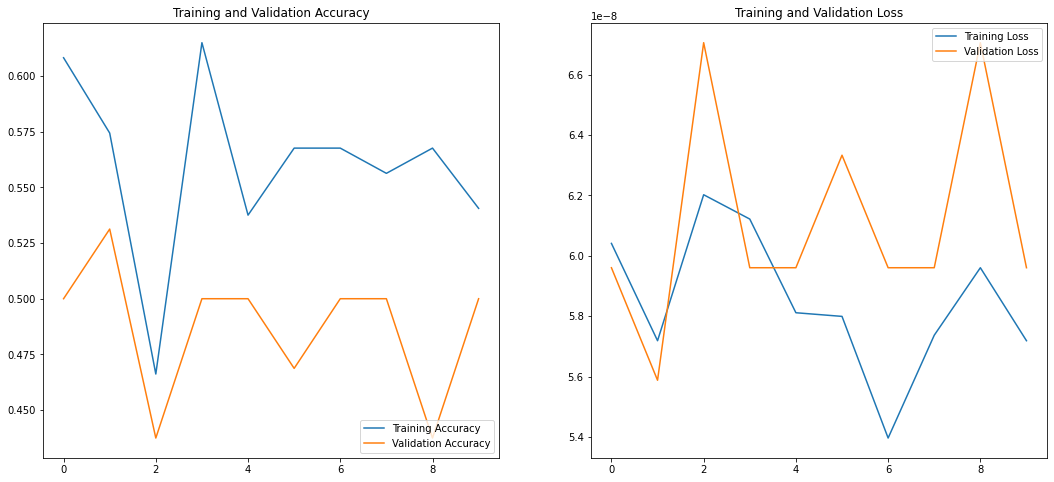

In [28]:
acc = hist_new.history['accuracy']
val_acc = hist_new.history['val_accuracy']

loss = hist_new.history['loss']
val_loss = hist_new.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
cn=confusion_matrix(y_actual,y_test)
print(metrics.classification_report(y_actual,y_test))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


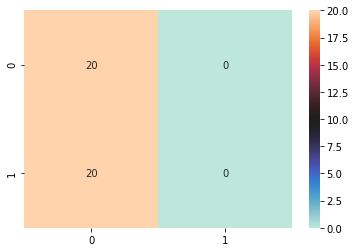

In [30]:
sns.heatmap(cn,cmap="icefire",annot=True)

2) WE BUILD OUR SECOND TYPE OF COMPLEX MODEL -

In [31]:
model2 = Sequential()

model2.add(Conv2D(64, kernel_size= (3,3), input_shape=(224,224, 3),padding='same'))
model2.add(BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))

model2.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model2.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.9))

model2.add(Conv2D(128, kernel_size =(3,3),padding='same'))
model2.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))

model2.add(Conv2D(128,(3,3), padding='same' ))
model2.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Conv2D(256, kernel_size = (3,3), padding='same'))
model2.add(BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))

model2.add(Conv2D(256, kernel_size= (3,3) ,padding='same'))
model2.add(BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(LeakyReLU(alpha=0.1))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
hist_new2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=5,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=1
    )

Epoch 1/10
5/5 [==============================] - 8s 2s/step - loss: 0.7728 - accuracy: 0.7838 - val_loss: 1.4785 - val_accuracy: 0.4688
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.2191 - accuracy: 0.8986 - val_loss: 0.8143 - val_accuracy: 0.4688
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.1586 - accuracy: 0.9257 - val_loss: 0.6782 - val_accuracy: 0.5625
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.0997 - accuracy: 0.9625 - val_loss: 0.4605 - val_accuracy: 0.7812
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.0701 - accuracy: 0.9730 - val_loss: 0.5283 - val_accuracy: 0.7188
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.1270 - accuracy: 0.9662 - val_loss: 0.4599 - val_accuracy: 0.7188
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.1059 - accuracy: 0.9730 - val_loss: 0.2769 - val_accuracy: 0.8438
Epoch 8/10
5/5 [=========================

In [33]:
summary2=hist_new2.history
print(summary2)

{'loss': [0.7728207111358643, 0.21907371282577515, 0.15863823890686035, 0.0996672660112381, 0.07008662819862366, 0.12704595923423767, 0.10591955482959747, 0.15121817588806152, 0.046390704810619354, 0.035070765763521194], 'accuracy': [0.7837837934494019, 0.8986486196517944, 0.9256756901741028, 0.9624999761581421, 0.9729729890823364, 0.9662162065505981, 0.9729729890823364, 0.9459459185600281, 0.9750000238418579, 0.9932432174682617], 'val_loss': [1.4784936904907227, 0.8142635822296143, 0.6781631112098694, 0.4604654312133789, 0.528309166431427, 0.45988041162490845, 0.276933878660202, 0.09090037643909454, 0.15241125226020813, 0.12819358706474304], 'val_accuracy': [0.46875, 0.46875, 0.5625, 0.78125, 0.71875, 0.71875, 0.84375, 0.96875, 0.9375, 0.90625]}


In [34]:
model2.save("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/model_covid2.h5")

EVALUATING OUR MODEL - 

In [35]:
print(model2.evaluate_generator(train_generator))
print(model2.evaluate_generator(validation_generator))

[0.5216244459152222, 0.7111111283302307]
[0.2087469846010208, 0.8500000238418579]


In [37]:
y_actual2 , y_test2 = [],[]
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/normal/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/normal/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=model2.predict_classes(img4)
    y_test2.append(pred[0,0])
    y_actual2.append(1)
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/covid/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/fortestingdataset/test/covid/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=model2.predict_classes(img4)
    y_test2.append(pred[0,0])
    y_actual2.append(0)
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

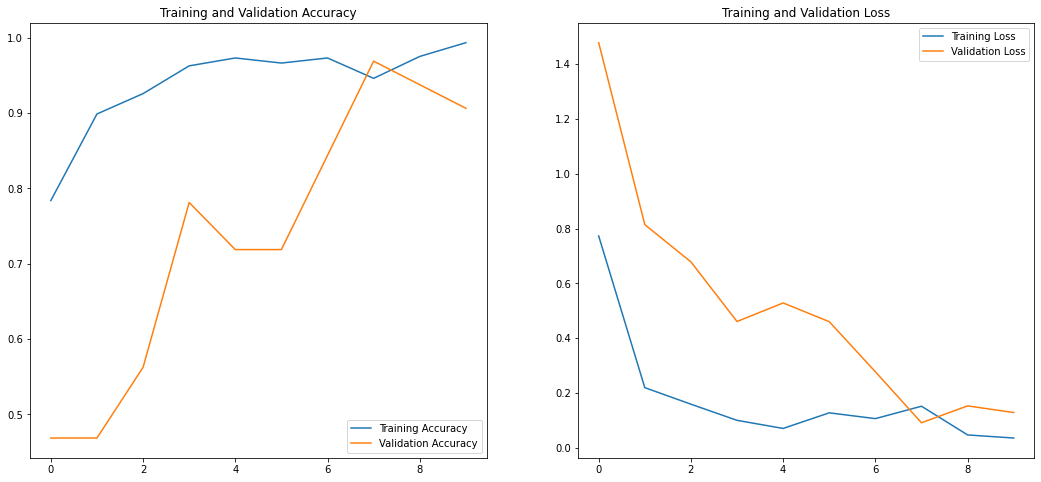

In [39]:
acc = hist_new2.history['accuracy']
val_acc = hist_new2.history['val_accuracy']

loss = hist_new2.history['loss']
val_loss = hist_new2.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.70      0.82        20

    accuracy                           0.85        40
   macro avg       0.88      0.85      0.85        40
weighted avg       0.88      0.85      0.85        40



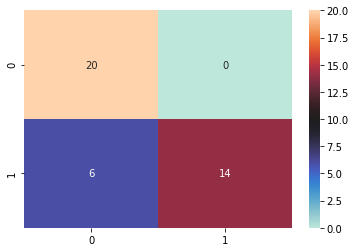

In [40]:
sns.heatmap(cn2,cmap="icefire",annot=True)

3) TRANSFER LEARNING - USING RESNET50V2 (GOOGLE'S STATE OF THE ART ARCHITECHTURE)

We know that the number of COVID-19 x-ray scans available to us is just 110. In real life, there are thousands of x-ray images of normal,viral and bacterial pneumonia which have very resembling scans and symptoms as of COVID-19. So we use transfer learning method and leverage the power of ResNet50V2 to tackle these imbalanced classes using class weights and correctly setting the initial bias to train our model.

We proceed in the same way as before. We make folders to store our our images.

We'll force our model to tackle class imbalance by putting only +ve covid images in the test folder

In [41]:
FORRESNET_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir"
if not os.path.exists(FORRESNET_DIR):
  os.mkdir(FORRESNET_DIR)
RESNET_TRAIN_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/train"
RESNET_TRAIN_COVID_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/train/covid"
RESNET_TRAIN_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/train/normal"
RESNET_TEST_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test"
RESNET_TEST_COVID_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/covid"
RESNET_TEST_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/normal"
if not os.path.exists(RESNET_TRAIN_DIR):
  os.mkdir(RESNET_TRAIN_DIR)
  os.mkdir(RESNET_TRAIN_COVID_DIR)
  os.mkdir(RESNET_TRAIN_NORMAL_DIR)
  os.mkdir(RESNET_TEST_DIR)
  os.mkdir(RESNET_TEST_COVID_DIR)
  os.mkdir(RESNET_TEST_NORMAL_DIR)
RESNET_COVID_METADATA_FILE_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/covid-chestxray-dataset-master/metadata.csv"
RESNET_COVID_IMAGES_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/covid-chestxray-dataset-master/images"
RESNET_KAGGLE_NORMAL_FILE_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (Pneumonia)/chest_xray/train/NORMAL"
RESNET_KAGGLE_PNEUMONIA_FILE_PATH = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (Pneumonia)/chest_xray/train/PNEUMONIA"
print("folders created")

folders created


In [ ]:
count = 0
for (i,row) in df.iterrows():
  if row["finding"] == "Pneumonia/Viral/COVID-19" and row["RT_PCR_positive"] == "Y" and row["view"] == "PA" :
    filename = row["filename"]
    image_path = os.path.join(RESNET_COVID_IMAGES_PATH,filename)
    image_copy_path = os.path.join(RESNET_TRAIN_COVID_DIR,filename)
    shutil.copy2(image_path,image_copy_path)
    count+=1
print("Copied +ve covid files to training data folder = ",count)

Copied +ve covid files to training data folder =  110


In [ ]:
image_normal_names = os.listdir(RESNET_KAGGLE_NORMAL_FILE_PATH)
image_pneumonia_names = os.listdir(RESNET_KAGGLE_PNEUMONIA_FILE_PATH)
random.shuffle(image_normal_names)
random.shuffle(image_pneumonia_names)

In [ ]:
count = 0
for i in range(len(image_normal_names)):
  image_name1 = image_normal_names[i]
  image_path1 = os.path.join(RESNET_KAGGLE_NORMAL_FILE_PATH,image_name1)
  target_path1 = os.path.join(RESNET_TRAIN_NORMAL_DIR,image_name1)
  shutil.copy2(image_path1,target_path1)
  count+=1
print("copied normal images to training folder = ",count)
count = 0
for i in range(len(image_pneumonia_names)):
  image_name1 = image_pneumonia_names[i]
  image_path1 = os.path.join(RESNET_KAGGLE_PNEUMONIA_FILE_PATH,image_name1)
  target_path1 = os.path.join(RESNET_TRAIN_NORMAL_DIR,image_name1)
  shutil.copy2(image_path1,target_path1)
  count+=1
print("copied pneumonia images to training folder = ",count)

copied normal images to training folder =  1583
copied pneumonia images to training folder =  4273


In [ ]:
image_names = os.listdir(RESNET_TRAIN_NORMAL_DIR)
random.shuffle(image_names)
count = 0
for i in range(3) :
  image_name2 = image_names[i]
  image_path2 = os.path.join(RESNET_TRAIN_NORMAL_DIR,image_name2)
  target_path2 = os.path.join(RESNET_TEST_NORMAL_DIR,image_name2)
  shutil.move(image_path2,target_path2)
  count+=1
print("Moved normal images to test folder = ",count)

Moved normal images to test folder =  3


In [ ]:
image_names = os.listdir(RESNET_TRAIN_COVID_DIR)
random.shuffle(image_names)
count = 0
for i in range(27) :
  image_name2 = image_names[i]
  image_path2 = os.path.join(RESNET_TRAIN_COVID_DIR,image_name2)
  target_path2 = os.path.join(RESNET_TEST_COVID_DIR,image_name2)
  shutil.move(image_path2,target_path2)
  count+=1
print("Moved covid images to test folder = ",count)

Moved covid images to test folder =  27


In [42]:
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)
test_dataset = image.ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/train",
    target_size = (224,224),
    batch_size = 25,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test",
    target_size = (224,224),
    batch_size = 25,
    class_mode = 'binary')

Found 5936 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [44]:
train_generator.class_indices

{'covid': 0, 'normal': 1}

In [56]:
from keras.applications import ResNet50V2
from keras.models import Model

In [57]:
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [58]:
resnet.trainable = False

In [59]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [60]:
pos = len(os.listdir(RESNET_TRAIN_COVID_DIR))
neg = len(os.listdir(RESNET_TRAIN_NORMAL_DIR))
total = pos+neg
weight_for_0 = (1 / pos)*(total)/2.0 
weight_for_1 = (1 / neg)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

In [61]:
initial_bias = np.log([pos/neg])
output_bias = keras.initializers.Constant(initial_bias)
print(output_bias)

In [62]:
resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dropout(0.001))
resnet_model.add(Dense(1, activation='sigmoid', bias_initializer = output_bias))
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 100353    
Total params: 23,665,153
Trainable params: 100,353
Non-trainable params: 23,564,800
_________________________________________________________________


In [63]:
resnet_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
resnet_hist = resnet_model.fit_generator(train_generator, 
                              steps_per_epoch=225, 
                              epochs=3,
                              validation_data=validation_generator, 
                              class_weight = class_weight,
                              validation_steps=1,
                              )

Epoch 1/3
225/225 [==============================] - 1034s 5s/step - loss: 3.7256 - accuracy: 0.9442 - val_loss: 4.5317e-11 - val_accuracy: 1.0000
Epoch 2/3
225/225 [==============================] - 150s 665ms/step - loss: 1.9310 - accuracy: 0.9554 - val_loss: 4.1636e-23 - val_accuracy: 1.0000
Epoch 3/3
225/225 [==============================] - 115s 513ms/step - loss: 1.3572 - accuracy: 0.9729 - val_loss: 7.6180e-24 - val_accuracy: 1.0000


In [65]:
summary=resnet_hist.history
print(summary)

{'loss': [3.7255823612213135, 1.9309947490692139, 1.3571792840957642], 'accuracy': [0.9442167282104492, 0.9554446339607239, 0.9729103446006775], 'val_loss': [4.531701749965755e-11, 4.1635905028165854e-23, 7.617965075125083e-24], 'val_accuracy': [1.0, 1.0, 1.0]}


In [66]:
resnet_model.save("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/model_covid3.h5")

In [67]:
y_actual3 , y_test3 = [],[]

In [68]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/normal/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/normal/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=resnet_model.predict_classes(img4)
    y_test3.append(pred[0,0])
    y_actual3.append(1)

In [69]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/covid/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/forresnetdir/test/covid/"+i,target_size=(224,224,3))
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=resnet_model.predict_classes(img4)
    y_test3.append(pred[0,0])
    y_actual3.append(0)

In [70]:
y_actual4=np.array(y_actual3)
y_test4=np.array(y_test3)

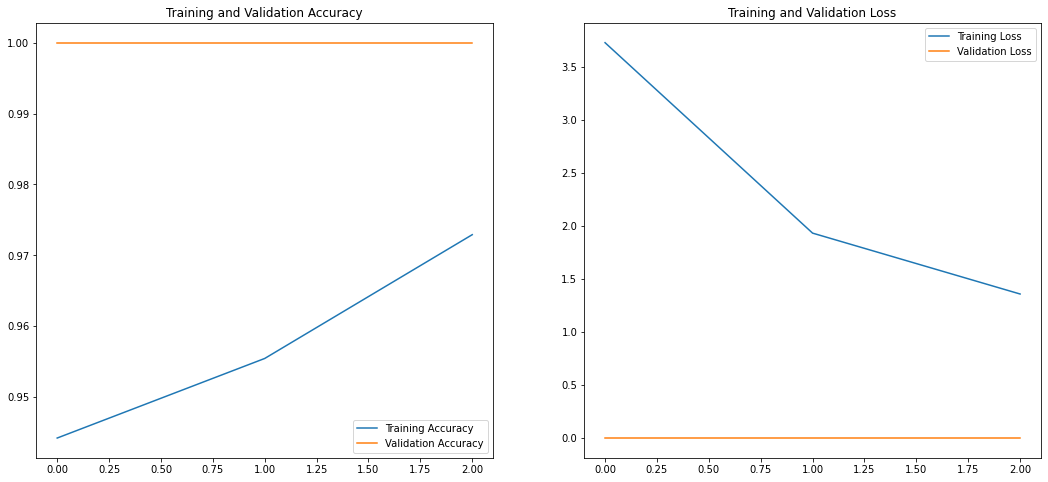

In [73]:
acc = resnet_hist.history['accuracy']
val_acc = resnet_hist.history['val_accuracy']

loss = resnet_hist.history['loss']
val_loss = resnet_hist.history['val_loss']
epochs_range = range(3)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
cn2=confusion_matrix(y_actual4,y_test4)
print(metrics.classification_report(y_actual4,y_test4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



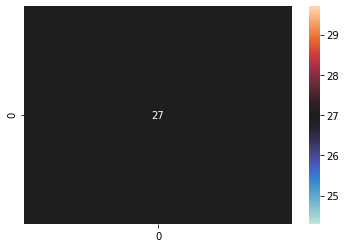

In [74]:
sns.heatmap(cn2,cmap="icefire",annot=True)

4) IMPLEMENTING A BASIC SKELETON THAT POWERS COVXNET (NETWORK-128) USING THE SAME METHOD OF TRANSFER LEARNING.
WE FIRST TRAIN OUR MODEL ON NORMAL/PNEUMONIA X-RAY SCANS. THEN BY TRANSFER LEARNING, WE TRAIN IT ON COVID IMAGES ALSO. 
COVXNET SURPASSES THE PERFORMANCE OF ALL THE MODELS AVAILABLE TO US. 

WE'LL IMPLEMEMT TRANSFER LEARNING IN THIS MODEL IN THE SAME WAY AS WE IMPLEMENTED IN THE RESNET50V2.

In [75]:
COVXNET_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray"
COVXNET_TRAIN_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/train"
COVXNET_TRAIN_PNEUMONIA_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/train/pneumonia"
COVXNET_TRAIN_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/train/normal"
COVXNET_TEST_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/test"
COVXNET_TEST_PNEUMONIA_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/test/pneumonia"
COVXNET_TEST_NORMAL_DIR = "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/test/normal"

In [76]:
def Residual_Unit(input_tensor, nb_of_input_channels, max_dilation, number_of_units):
    
  for i in range(number_of_units):
    x1 = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)
  
    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)
    x = Conv2D(nb_of_input_channels, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_tensor])

    input_tensor = x
  
  return x

In [77]:
def Shifter_Unit(input_tensor, nb_of_input_channels, max_dilation):
    x1 = Conv2D(nb_of_input_channels*4, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)

    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = MaxPool2D(pool_size=(2,2))(temp)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)

    x = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    return x

In [78]:
def Network128(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  x = Dense(2, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics = [tf.keras.metrics.AUC(),"accuracy"])

  return model

In [79]:
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)
test_datagen = image.ImageDataGenerator(rescale= 1./255)

In [80]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/train",
    target_size = (128,128),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )
test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/test",
    target_size = (128,128),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )

Found 5219 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [81]:
train_generator.class_indices

{'normal': 0, 'pneumonia': 1}

In [82]:
covxnet128_model = Network128(input_shape = (128, 128, 1), nb_class = 2, depth = 5)
covxnet128_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 416         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 128, 128, 16) 64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 32)   4640        batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [83]:
covxnet128_hist = covxnet128_model.fit(x=train_generator,
                              validation_data=test_generator,
                              steps_per_epoch = 150,
                              validation_steps= 15,
                              epochs = 10
                              )

Epoch 1/10
150/150 [==============================] - 1434s 10s/step - loss: 0.3084 - auc: 0.9442 - accuracy: 0.8604 - val_loss: 4.0140 - val_auc: 0.6292 - val_accuracy: 0.6292
Epoch 2/10
150/150 [==============================] - 223s 1s/step - loss: 0.2293 - auc: 0.9688 - accuracy: 0.9071 - val_loss: 3.3981 - val_auc: 0.6333 - val_accuracy: 0.6333
Epoch 3/10
150/150 [==============================] - 187s 1s/step - loss: 0.2013 - auc: 0.9753 - accuracy: 0.9219 - val_loss: 4.0646 - val_auc: 0.6458 - val_accuracy: 0.6458
Epoch 4/10
150/150 [==============================] - 187s 1s/step - loss: 0.1735 - auc: 0.9812 - accuracy: 0.9348 - val_loss: 3.2815 - val_auc: 0.6354 - val_accuracy: 0.6354
Epoch 5/10
150/150 [==============================] - 186s 1s/step - loss: 0.1702 - auc: 0.9820 - accuracy: 0.9375 - val_loss: 2.1909 - val_auc: 0.7556 - val_accuracy: 0.6542
Epoch 6/10
150/150 [==============================] - 186s 1s/step - loss: 0.1646 - auc: 0.9830 - accuracy: 0.9377 - val_lo

In [98]:
resnet_model.save("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/model_covid4.h5")

In [99]:
validation_datagen = image.ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        "/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/val",
         target_size = (128,128),
         color_mode='grayscale',
         batch_size = 32,
         class_mode = 'categorical'
         )

Found 40 images belonging to 2 classes.


In [100]:
covxnet128_model.evaluate(
    x=validation_generator,
    return_dict=True
)

2/2 [==============================] - 0s 36ms/step - loss: 0.1885 - auc: 0.9750 - accuracy: 0.9500


{'accuracy': 0.949999988079071,
 'auc': 0.9750000238418579,
 'loss': 0.18853774666786194}

In [88]:
summary=covxnet128_hist.history
print(summary)

{'loss': [0.30840545892715454, 0.2293468564748764, 0.2013232707977295, 0.17345894873142242, 0.1701716035604477, 0.16455809772014618, 0.1601981818675995, 0.16686001420021057, 0.14415785670280457, 0.15446335077285767], 'auc': [0.9441789388656616, 0.9688241481781006, 0.9752974510192871, 0.9812310934066772, 0.9819701313972473, 0.9829640984535217, 0.9838564991950989, 0.982621967792511, 0.986709475517273, 0.9848673343658447], 'accuracy': [0.8604066371917725, 0.9071473479270935, 0.921875, 0.9348145127296448, 0.937539279460907, 0.937748908996582, 0.9411025047302246, 0.93729168176651, 0.9440369009971619, 0.9429888725280762], 'val_loss': [4.014035701751709, 3.398074150085449, 4.064624309539795, 3.2815139293670654, 2.1908833980560303, 0.2980230450630188, 0.3499460220336914, 0.46129530668258667, 0.3847097158432007, 0.32526037096977234], 'val_auc': [0.6291666030883789, 0.6333333253860474, 0.6458333134651184, 0.6354166269302368, 0.755551278591156, 0.9533072710037231, 0.9460763931274414, 0.9199478626

In [102]:
pred=covxnet128_model.predict_generator(validation_generator, verbose=1)
cl = np.round(pred)
filenames=validation_generator.filenames
results=pd.DataFrame({"file":filenames,"pr":pred[:,0], "class":cl[:,0]})
print(results)

2/2 [==============================] - 0s 169ms/step
                                file        pr  class
0           normal/IM-0001-0001.jpeg  0.152646    0.0
1           normal/IM-0003-0001.jpeg  0.036836    0.0
2           normal/IM-0005-0001.jpeg  0.003466    0.0
3           normal/IM-0006-0001.jpeg  0.992762    1.0
4           normal/IM-0007-0001.jpeg  0.917746    1.0
5           normal/IM-0009-0001.jpeg  0.999159    1.0
6           normal/IM-0010-0001.jpeg  0.950339    1.0
7      normal/IM-0011-0001-0001.jpeg  0.999408    1.0
8      normal/IM-0011-0001-0002.jpeg  0.999986    1.0
9           normal/IM-0011-0001.jpeg  0.156674    0.0
10          normal/IM-0013-0001.jpeg  0.006516    0.0
11          normal/IM-0015-0001.jpeg  0.999635    1.0
12          normal/IM-0016-0001.jpeg  0.171975    0.0
13          normal/IM-0017-0001.jpeg  0.071652    0.0
14          normal/IM-0019-0001.jpeg  0.062694    0.0
15          normal/IM-0021-0001.jpeg  0.008504    0.0
16          normal/IM-0022-00

In [103]:
y_actual2 , y_test2 = [],[]

In [104]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/val/pneumonia/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/val/pneumonia/"+i,target_size=(128,128),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=covxnet128_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(1)

In [105]:
for i in os.listdir("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/val/normal/"):
    img=image.load_img("/content/drive/MyDrive/Tanweer Internships & Jobs/Hackathons & Projects/COVID-19 DETECTOR/Chest X-Ray Images (All)/chest_xray/val/normal/"+i,target_size=(128,128),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=covxnet128_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(0)

In [106]:
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

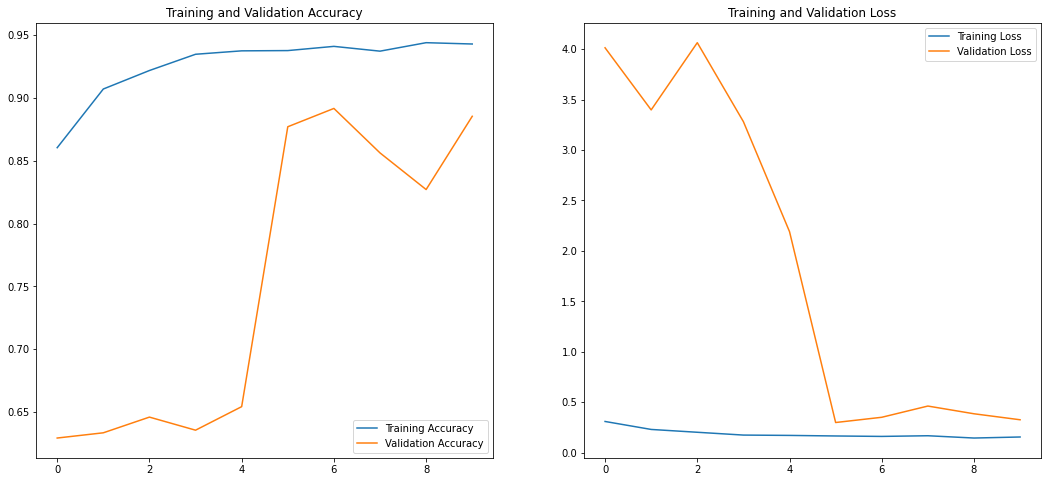

In [108]:
acc = covxnet128_hist.history['accuracy']
val_acc = covxnet128_hist.history['val_accuracy']

loss = covxnet128_hist.history['loss']
val_loss = covxnet128_hist.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



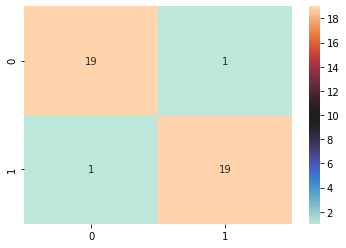

In [109]:
sns.heatmap(cn2,cmap="icefire",annot=True)